## Using PLUMED to do MetaDynamics

In [212]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git
from funcs import view_nucl


import matplotlib.pyplot as plt

import MDAnalysis.analysis.pca as pca
import MDAnalysis.analysis.encore as encore
from MDAnalysis.analysis.rms import RMSF

from seq_tools.plot4seq import plot_prof4seq
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import seq1
from seq_tools.hist_ss import get_hist_ss_in_aln_for_shade
import numpy as np
import xvg_plot as xvg
import xpm_plot as xpm

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)


%matplotlib inline
%load_ext rpy2.ipython

from config import movtitle
from IPython.display import Markdown, display
from config import folder,descr,pname,ssh_host
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)
print("SSH host set to:",ssh_host)



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython



# MD simulations of H3-H4 with 30 bp of DNA, tails truncated
- AMBER14SB force field
- 150 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm_30DNA
Project name:  h3-h4_tm_30DNA
SSH host set to: lomo2g


### CVs should be tested in notebook 7_plumed....

## DNA ANGLE

In [169]:
import MDAnalysis as mda
import MDAnalysis.analysis.hbonds
import MDAnalysis.analysis.distances

#Let's load a structure with hydrogens, assumed the numbering is the same with full system, since water and ions are added to the end.
sys=mda.Universe("GMX_system/sys_ref.pdb")
#sys=mda.Universe("GMX_system/sys_ref.pdb",'big_data/sys_md.xtc')



#the chains have already been renamed by gromacs I=>A J=>B

sel_end1="(segid I and resnum -1) or (segid J and resnum 1)"
sel_end2="(segid I and resnum -30) or (segid J and resnum 30)"
sel_mid="(segid I and resnum -15) or (segid J and resnum 15)"

E1=sys.select_atoms(sel_end1)
E2=sys.select_atoms(sel_end2)
Em=sys.select_atoms(sel_mid)



a=nv.show_mdanalysis(sys)
#a.add_representation('licorice',selection='all')
a.add_representation('spacefill',selection='@'+','.join([str(i.id-1) for i in E1.atoms]), color='green')
a.add_representation('spacefill',selection='@'+','.join([str(i.id-1) for i in E2.atoms]), color='magenta')
a.add_representation('spacefill',selection='@'+','.join([str(i.id-1) for i in Em.atoms]), color='blue')


a.camera = 'orthographic'
a


NGLWidget()

In [43]:
from numpy.linalg import norm
print("Initial distance =",norm(E1.center_of_mass() - E2.center_of_mass())/10," nm\n\n")
end1at=','.join([str(i.id) for i in E1.atoms])
end2at=','.join([str(i.id) for i in E2.atoms])
midat=','.join([str(i.id) for i in Em.atoms])
chainIat=','.join([str(i.id) for i in sys.select_atoms("segid I").atoms])
chainJat=','.join([str(i.id) for i in sys.select_atoms("segid J").atoms])



#Now let's write a plumed.dat file
#NOTE: wholemolecules and NOPBC are crucial!!!

!echo "WHOLEMOLECULES ENTITY0=$chainIat ENTITY1=$chainJat" >GMX_run/plumed_a1.dat
!echo "end1: GROUP ATOMS=$end1at" >>GMX_run/plumed_a1.dat
!echo "end2: GROUP ATOMS=$end2at" >>GMX_run/plumed_a1.dat
!echo "mid: GROUP ATOMS=$midat" >>GMX_run/plumed_a1.dat
!echo "com_end1: COM ATOMS=end1" >>GMX_run/plumed_a1.dat
!echo "com_end2: COM ATOMS=end2" >>GMX_run/plumed_a1.dat
!echo "com_mid: COM ATOMS=mid" >>GMX_run/plumed_a1.dat
!echo "a1: ANGLE ATOMS=com_end1,com_mid,com_end2 NOPBC" >>GMX_run/plumed_a1.dat
#This is a well-tempered MetaD setup
#!echo "meta: METAD ARG=a1 BIASFACTOR=10.0 TEMP=300.0 SIGMA=0.2 HEIGHT=1 PACE=100 FILE=HILLS_a1.dat GRID_MIN=0 GRID_MAX=pi WALKERS_MPI" >>GMX_run/plumed_a1.dat
#This is a usual MetaD setup
!echo "meta: METAD ARG=a1 SIGMA=0.2 HEIGHT=1 PACE=100 FILE=HILLS_a1.dat GRID_MIN=0 GRID_MAX=pi WALKERS_MPI" >>GMX_run/plumed_a1.dat

#!echo "PRINT ARG=a1 FILE=colvar.dat STRIDE=10" >>GMX_run/plumed.dat
!cat GMX_run/plumed_a1.dat

Initial distance = 7.513728711238359  nm


WHOLEMOLECULES ENTITY0=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,26

## Prepare new tpr-file!

In [58]:
!cp GMX_run/7_prod.tpr GMX_run/plumed_7_prod.tpr
!cp GMX_run/7_prod_10ps_out.tpr GMX_run/plumed_7_prod_10ps_out.tpr

# =============Run=============

In [ ]:
#Local run
#%%bash
#cd GMX_run
#mpirun -np 1  mdrun_mpi -ntomp 10 -deffnm plumed_7_prod -plumed plumed_a1.dat 
#mpirun -np 1  mdrun_mpi -ntomp 10 -deffnm plumed_7_prod_10ps_out -plumed plumed_a1.dat 




In [74]:
#Run on Lomonosov
#Transfer
!ssh $ssh_host "mkdir -p ~/_scratch/$folder"
!cp Run_scripts/lomo2_run_plumed.sh GMX_run/
#!cp Run_scripts/lomo2_run_cont_plumed.sh GMX_run/
!rsync --exclude '*.xtc' --exclude '*.trr' -r GMX_run $ssh_host:~/_scratch/$folder/;


   Lomonosov-2 supercomputer welcomes you!


   Lomonosov-2 supercomputer welcomes you!




In [118]:
%%bash -s "$folder" "$ssh_host" 
#Launching initially!!!
ssh $2 "source /etc/profile; export MODULEPATH=\$MODULEPATH:/home/satary_1609/_scratch/_software/modules; module load slurm gromacs_2019.2_plumed; cd ~/_scratch/$1/GMX_run; sbatch -p compute -t 7-00:00:00 -N 4 -J plumed_$1 lomo2_run_plumed.sh plumed_7_prod plumed_a1.dat"



Submitted batch job 1055614


   Lomonosov-2 supercomputer welcomes you!




In [190]:
!ssh $ssh_host "module load slurm gromacs/2018-gcc; squeue -u \`whoami\` " || echo "No job in queue"

   Lomonosov-2 supercomputer welcomes you!


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1053299   compute H2A.Z_NC gorkovet PD       0:00      4 (Dependency)
           1053303   compute 3lz0_ntm gorkovet PD       0:00      4 (Dependency)
           1056723   compute H2A.Z_NC gorkovet PD       0:00      4 (Dependency)
           1057470   compute 3lz0_ntm gorkovet PD       0:00      4 (Dependency)
           1053296   compute 3lz0_ntm gorkovet  R 1-20:47:09      4 n[48318,49026,53613-53614]
           1053298   compute H2A.Z_NC gorkovet  R 2-10:02:28      4 n[48021,49015-49017]
           1055465   compute h3-h4_tm gorkovet  R 2-00:36:54      4 n[51119,51125,51231,51332]
           1055614   compute plumed_h gorkovet  R 1-20:41:59      4 n[49115-49116,49629-49630]


In [211]:
!ssh $ssh_host "module load slurm gromacs/2018-gcc; squeue -n plumed_$folder " || echo "No job in queue"

   Lomonosov-2 supercomputer welcomes you!


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1055614   compute plumed_h gorkovet  R 1-21:02:44      4 n[49115-49116,49629-49630]


In [ ]:
%%bash -s "$folder" "$ssh_host" 
#Relaunch
ssh $2 "source /etc/profile; export MODULEPATH=\$MODULEPATH:/home/satary_1609/_scratch/_software/modules; module load slurm gromacs_2019.2_plumed; cd ~/_scratch/$1/GMX_run; sbatch -p compute -t 7-00:00:00 -N 4 -J plumed_$1 lomo2_run_plumed_cont.sh plumed_7_prod plumed_a1.dat"

#Relaunch for non-plumed runs
##!ssh $ssh_host "module load slurm gromacs/2018-gcc; cd ~/_scratch/$folder/GMX_run; sbatch -p compute -t 7-00:00:00 -N 4 -J $folder lomo2_run_cont.sh 7_prod"

In [ ]:
%%bash -s "$folder" "$ssh_host" 
#Make a chain of tasks
#set --dependency=afterany:970076
#ssh $2 "source /etc/profile; export MODULEPATH=\$MODULEPATH:/home/satary_1609/_scratch/_software/modules; module load slurm gromacs_2019.2_plumed; cd ~/_scratch/$1/GMX_run; sbatch -p compute -t 7-00:00:00 -N 4 -J plumed_$1 --dependency=afterany:970076 lomo2_run_plumed_cont.sh plumed_7_prod plumed_a1.dat"


In [198]:
#Check status
!ssh $ssh_host "tail -n 50 ~/_scratch/$folder/GMX_run/plumed_7_prod.log | grep -A1 Time"

   Lomonosov-2 supercomputer welcomes you!


           Step           Time
       27079000    54158.00000
--
           Step           Time
       27080000    54160.00000
--
           Step           Time
       27081000    54162.00000


In [205]:
%%bash -s "$folder" "$ssh_host" --err err --out out
#Get back data

rsync --partial $2:~/_scratch/$1/GMX_run/plumed_7_prod* GMX_run/ ;
rsync --partial $2:~/_scratch/$1/GMX_run/HILL* GMX_run/ ;
rsync --partial $2:~/_scratch/$1/GMX_run/egmx* GMX_run/ ;    
rsync --partial $2:~/_scratch/$1/GMX_run/ogmx* GMX_run/ ;      

## ==========Analysis========

In [206]:
#Preprocees trj
#!./5_trj_preprocessing.sh plumed_7_prod_10ps_out plumed_md
!./5_trj_preprocessing.sh plumed_7_prod plumed_md

gmx: Relink `/opt/miniconda3/envs/moldyn/bin/../lib/././libgfortran.so.4' with `/lib/x86_64-linux-gnu/librt.so.1' for IFUNC symbol `clock_gettime'
                     :-) GROMACS - gmx trjconv, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess

Clustering iteration 4 of 4...00.000   
Clustering iteration 4 of 4...00.000   
Clustering iteration 4 of 4...00.000   
Clustering iteration 4 of 4...00.000   
Clustering iteration 4 of 4...00.000   
Clustering iteration 4 of 4...00      
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...00.000   
Clustering iteration 4 of 4...00      
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...00.000   
Clustering iteration 4 of 4...00      
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering iteration 4 of 4...
Clustering ite

In [207]:
view_nucl('GMX_system/sys_ref.pdb','big_data/plumed_md.xtc')

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=55)

In [208]:
!tail GMX_run/HILLS_a1.dat

      54198.20257427637  0.0002856475604654844                    0.2                      1                     -1
      54198.40257428586  0.0002310215384534003                    0.2                      1                     -1
      54198.60257429536  0.0004684572260864853                    0.2                      1                     -1
      54198.80257430486  0.0002059363198844028                    0.2                      1                     -1
      54199.00257431436  0.0003869670028291586                    0.2                      1                     -1
      54199.20257432386  0.0002289904552636749                    0.2                      1                     -1
      54199.40257433336  0.0004266766888116169                    0.2                      1                     -1
      54199.60257434286  0.0003075090723164052                    0.2                      1                     -1
      54199.80257435236  0.0001728333542525227                    0.2   

#! FIELDS time a1 sigma_a1 height biasf
#! SET multivariate false
#! SET kerneltype gaussian
     0.2000000094994903      2.003470084282284                    0.2                      1                     -1
     0.4000000189989805      2.009451804092433                    0.2                      1                     -1
     0.6000000284984708      2.011804933057795                    0.2                      1                     -1
      0.800000037997961      2.009244498139918                    0.2                      1                     -1
      1.000000047497451       2.00893602214278                    0.2                      1                     -1
      1.200000056996942         2.004827196314                    0.2                      1                     -1
      1.400000066496432      2.006322446743039                    0.2                      1                     -1
Labels found: ['time', 'a1', 'sigma_a1', 'height', 'biasf']


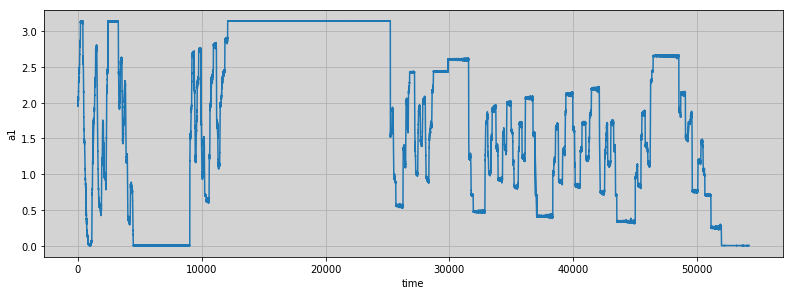

Labels found: ['time', 'a1', 'sigma_a1', 'height', 'biasf']


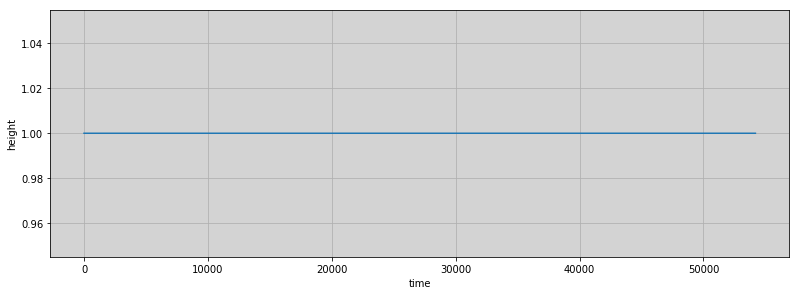

array([[ 2.00000009e-01,  2.00347008e+00,  2.00000000e-01,
         1.00000000e+00, -1.00000000e+00],
       [ 4.00000019e-01,  2.00945180e+00,  2.00000000e-01,
         1.00000000e+00, -1.00000000e+00],
       [ 6.00000028e-01,  2.01180493e+00,  2.00000000e-01,
         1.00000000e+00, -1.00000000e+00],
       ...,
       [ 5.41992026e+04,  2.28990455e-04,  2.00000000e-01,
         1.00000000e+00, -1.00000000e+00],
       [ 5.41994026e+04,  4.26676689e-04,  2.00000000e-01,
         1.00000000e+00, -1.00000000e+00],
       [ 5.41996026e+04,  3.07509072e-04,  2.00000000e-01,
         1.00000000e+00, -1.00000000e+00]])

In [209]:
from importlib import reload 
import funcs
reload(funcs)
from funcs import plot_plumed
import numpy as np
%matplotlib inline
!head -n -2 GMX_run/HILLS_a1.dat > GMX_run/HILLS_a1r.dat
!head GMX_run/HILLS_a1r.dat
plot_plumed('GMX_run/HILLS_a1r.dat',figsize=(15,5),col2plot=[1])
plot_plumed('GMX_run/HILLS_a1r.dat',figsize=(15,5),col2plot=[3])

#! FIELDS a1 file.free der_a1
#! SET min_a1 -0.707103
#! SET max_a1 3.8487
#! SET nbins_a1  66
#! SET periodic_a1 false
   -0.707103000 2122.487219933  -39.160573481
   -0.637013723 2117.327642357 -120.331130426
   -0.566924446 2102.802068219 -321.754965217
   -0.496835169 2066.863017628 -752.382206359
   -0.426745892 1989.036088381 -1535.045810770
Labels found: ['time', 'a1', 'sigma_a1', 'height', 'biasf']


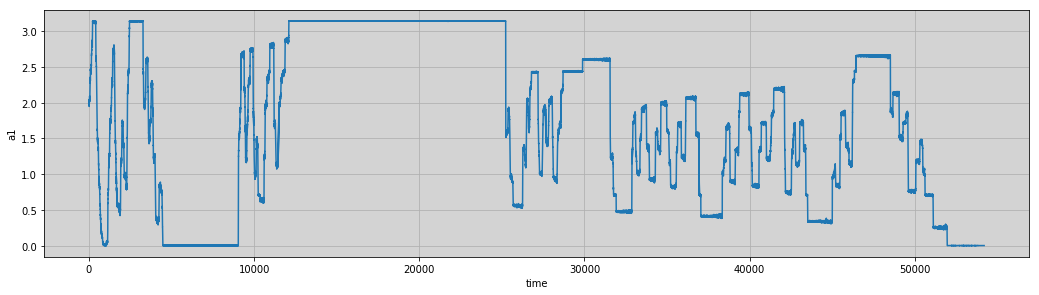

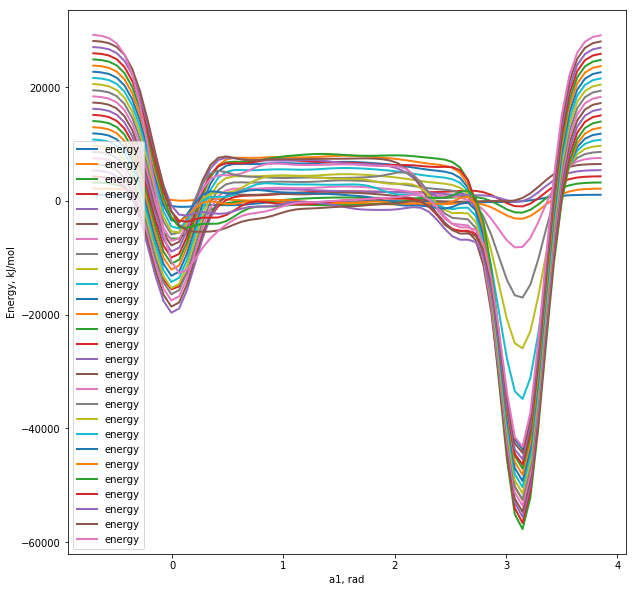

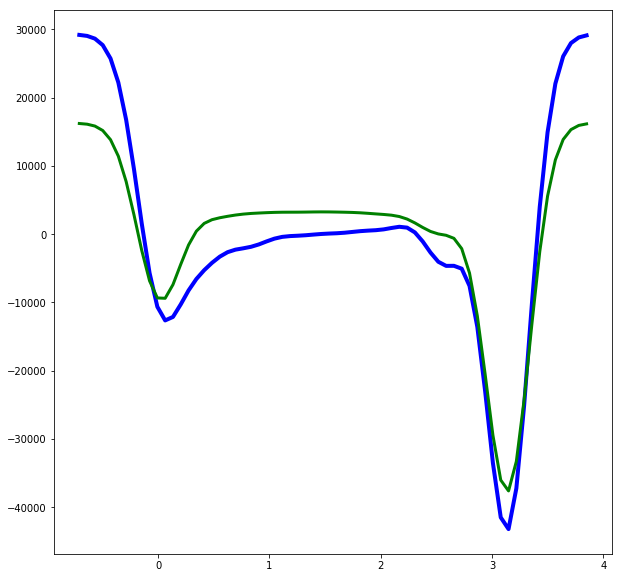

In [210]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

!mkdir -p big_data
stride=10000
!plumed sum_hills --stride $stride  --hills GMX_run/HILLS_a1r.dat --outfile big_data/sumhills_a1.dat --mintozero >/dev/null
!head big_data/sumhills_a1.dat0.dat

d=plot_plumed('GMX_run/HILLS_a1r.dat',figsize=(20,5),col2plot=[1]) 
#d=plot_plumed('GMX_run/HILLS_a1r.dat',figsize=(20,5),col2plot=[3]) 



sum_df=pd.DataFrame()



plt.figure(figsize=(10,10))
for i in range(int(len(d)/stride)):
    data=plot_plumed('big_data/sumhills_a1.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
#     plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
    plt.plot(df['angle'],df['energy'],linewidth=2)


#plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('a1, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.plot(df['angle'],df['energy'],'b-',linewidth=4)
#plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>1].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].mean(),'g-',linewidth=3)





## Important conclusion is that angle CV behaves incorrectly at 0 and pi.